# YOLO Inference
This notebook makes inference from the trained model.  
It also draws the image and the bounding boxes.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [2]:
# Helper function. This also includes the model class
import yoloHelpers as yolo

In [9]:
plt.rcParams['figure.dpi'] = 300 # to increase figure sizes
plt.rcParams["savefig.bbox"] = 'tight'

In [4]:
voc_classes = ["background", "aeroplane", "bicycle", "bird", "boat",
               "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
               "sofa", "train", "tvmonitor"]

## Load the model and the weights

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model_wts = "yoloWeights_20220625.pth"
model = yolo.Yolo().to(device)
model.load_state_dict(torch.load(model_wts))
model.eval()

Using cuda device


Yolo(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.1

## Load Images
I draw samples from training set and from the validation set

In [7]:
data_folder = "./data" # USE THIS FOR COLAB
data_folder = "/vol/data/dataLocal/PyTorchData" # for local

img_transform = transforms.Compose(
    [transforms.Resize([448, 448]),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])

# used for inference
train_set = torchvision.datasets.VOCDetection(root=data_folder, year="2012", image_set="train",
                                        download=False, transform=img_transform) #transforms.PILToTensor())
# used for plotting
train_set2 = torchvision.datasets.VOCDetection(root=data_folder, year="2012", image_set="train",
                                        download=False, transform=transforms.PILToTensor())

val_set = torchvision.datasets.VOCDetection(root=data_folder, year="2012", image_set="val",
                                           download=False, transform=img_transform)
val_set2 = torchvision.datasets.VOCDetection(root=data_folder, year="2012", image_set="val",
                                           download=False, transform=transforms.PILToTensor())

### Training Sample

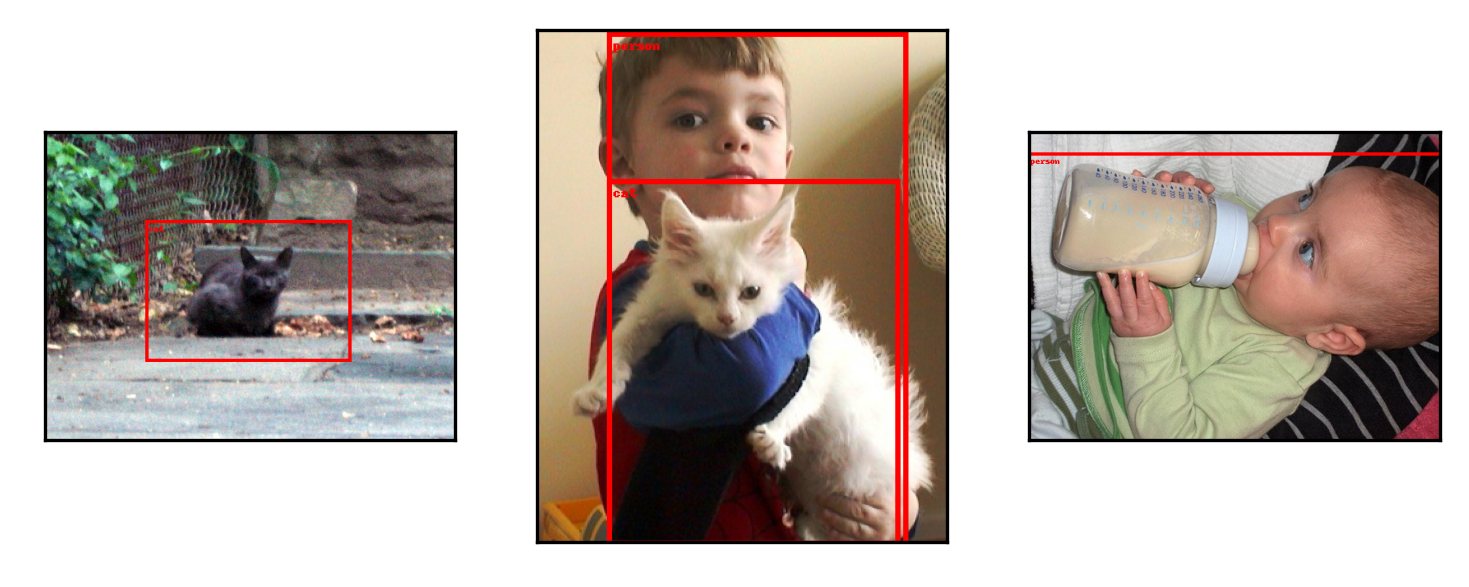

In [16]:
# random image
num_images = 3
#idx = random.randint(0, len(val_set))
idx = random.sample(range(len(train_set)), num_images)
images = []
for i in idx:
    img_T, gt = train_set[i] # in tensor format
    img, annotation = train_set2[i] # in img & dict format for the labels
    img_T = img_T.to(device).unsqueeze(0)
    pred = model(img_T)
    # Convert pred tensor to bounding box
    pred = pred.detach().cpu().numpy()[0]
    img_x = int(annotation['annotation']['size']['width'])
    img_y = int(annotation['annotation']['size']['height'])
    pred_boxes = yolo.pred_to_box(pred, img_x=img_x, img_y=img_y, label_decode=True)
    images.append(draw_bounding_boxes(img, 
                             boxes = torch.tensor(pred_boxes['boxes']),
                             width = 4, colors = 'red',
                             labels = pred_boxes['labels']))
yolo.show(images)

### Test Sample

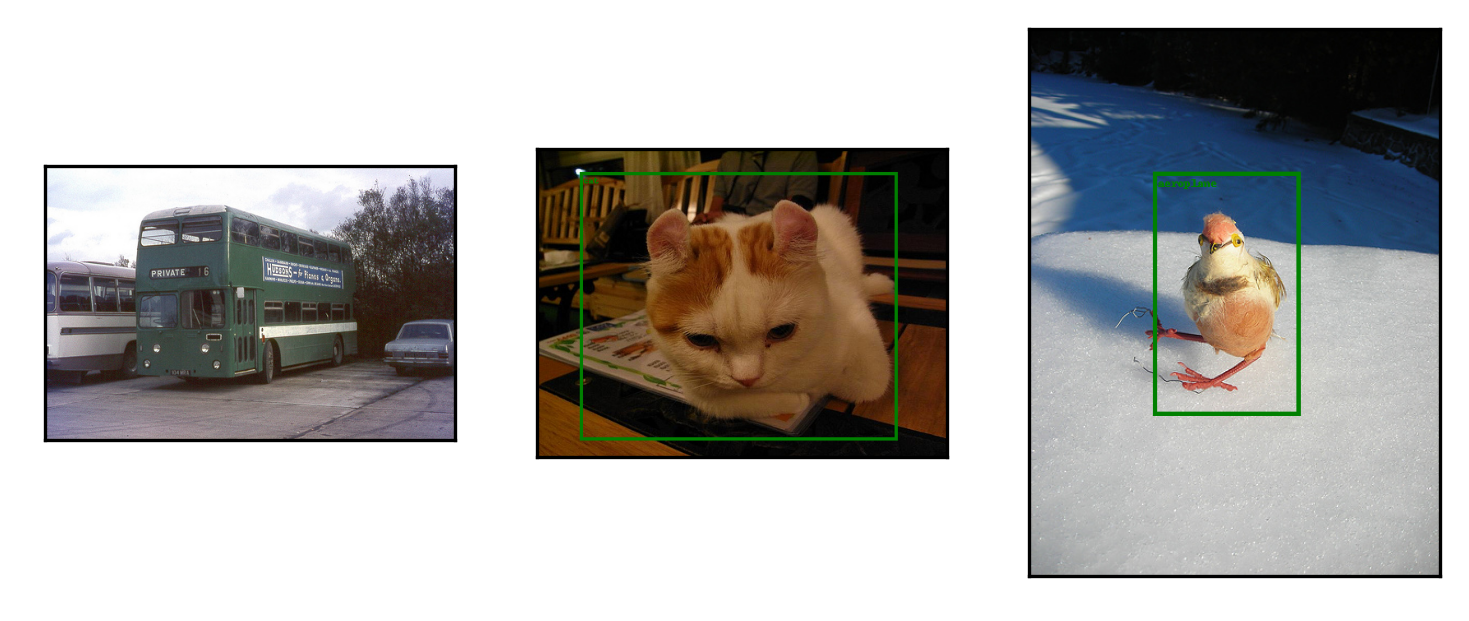

In [23]:
# random image
num_images = 3
#idx = random.randint(0, len(val_set))
idx = random.sample(range(len(val_set)), num_images)
images = []
for i in idx:
    img_T, gt = val_set[i] # in tensor format
    img, annotation = val_set2[i] # in img & dict format for the labels
    img_T = img_T.to(device).unsqueeze(0)
    pred = model(img_T)
    # Convert pred tensor to bounding box
    pred = pred.detach().cpu().numpy()[0]
    img_x = int(annotation['annotation']['size']['width'])
    img_y = int(annotation['annotation']['size']['height'])
    pred_boxes = yolo.pred_to_box(pred, img_x=img_x, img_y=img_y, label_decode=True)
    images.append(draw_bounding_boxes(img, 
                             boxes = torch.tensor(pred_boxes['boxes']),
                             width = 4, colors = 'green',
                             labels = pred_boxes['labels']))
yolo.show(images)

### Conclusion
The model shows clear signs of over fitting. The training predictions are good, but the test predictions are not.  
This was expected because we trained the model with few number of images (~5700 image), and we didn't use data augmenttaion.
